In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from helpers.readers import read_dataframe

# Load datasets and prepare merged dataframes

In [6]:
cmu_movies = read_dataframe(
    name='cmu/movies',
    preprocess=True,
    usecols=[
        "Wikipedia movie ID",
        "Freebase movie ID",
        "Movie name",
        "Movie release date",
        "Movie box office revenue",
        "Movie runtime",
        "Movie languages",
        "Movie countries",
        "Movie genres",
    ]
)
imdb_info = read_dataframe(name='imdb/movies', preprocess=True)
imdb_ratings = read_dataframe(name='imdb/ratings')
movieLens_movies = read_dataframe(name='movieLens/movies', preprocess=True)
movieLens_ratings = read_dataframe('movieLens/ratings')

imdb_crew = read_dataframe(name='imdb/crew')
imdb_people = read_dataframe(name='imdb/names')
imdb_principals = read_dataframe(name='imdb/principals')

Preprocess logs:
✅ Fixed Movie Languages inside Movie Countries
✅ Removed Deseret characters
✅ Movie release date splitted to three columns: Movie release Year, Movie release Month, Movie release Day
✅ Seperated freebase identifiers from Movie Languages, Movie Countries and Movie Genres
Preprocess logs:
✅ Moved genres from runtimeMinutes to genres column
Preprocess logs:
✅ Aligned bad rows


## Prepare the movies dataframe

In [7]:
mapping_w_i_f = read_dataframe(name='mapping_wikipedia_imdb_freebase')
mapping_f_i = read_dataframe(name='mapping_freebase_imdb')

In [8]:
movies = cmu_movies.drop(['Movie release Day', 'Movie release Month'], axis=1).copy()

In [9]:
movies.rename(
    columns={
        'Wikipedia movie ID': 'wikipediaID',
        'Freebase movie ID': 'freebaseID',
        'Movie name': 'title',
        'Movie box office revenue': 'revenue',
        'Movie runtime': 'runtime',
        'Movie languages': 'languages',
        'Movie countries': 'countries',
        'Movie genres': 'genres',
        'Movie release Year': 'release',
    },
    inplace=True,
)

In [10]:
movies = movies.merge(
    right=mapping_f_i.drop_duplicates(subset='freebase'),
    left_on='freebaseID', right_on='freebase', how='left'
).rename(columns={'imdb': 'tconst'}).drop('freebase', axis=1)

In [11]:
movies.tconst.duplicated().sum()
movies.drop_duplicates(subset='tconst', inplace=True)

In [12]:
movies = movies.merge(
    right=imdb_info.rename(columns={'genres': 'genres_imdb', 'runtimeMinutes': 'runtime_imdb'})[['tconst', 'isAdult', 'runtime_imdb', 'genres_imdb']],
    on='tconst', how='left',
)

In [13]:
movies = movies.merge(
    right=imdb_ratings.rename(columns={'averageRating': 'rating', 'numVotes': 'votes'}),
    on='tconst', how='left',
)

In [12]:
# NOTE: Only adds ratings for 100 movies, not worth it

# movies = movies.merge(
#     right=movieLens_movies[['vote_average', 'vote_count', 'imdb_id']].rename(columns={'vote_average': 'rating_lens', 'vote_count': 'votes_lens', 'imdb_id': 'tconst'}),
#     on='tconst', how='left',
# )
# movies.rating_lens.replace(to_replace=0, value=pd.NA)

In [14]:
movies = movies.merge(right=imdb_crew.drop('writers', axis=1), on='tconst', how='left')

In [15]:
movies

,wikipediaID,freebaseID,title,revenue,runtime,release,languages,countries,genres,tconst,isAdult,runtime_imdb,genres_imdb,rating,votes,directors
0,975900,/m/03vyhn,Ghosts of Mars,14010832.0,98.0,2001,English,United States of America,"Thriller,Science Fiction,Horror,Adventure,Supe...",tt0228333,0,98,"Action,Horror,Sci-Fi",4.9,56690.0,nm0000118
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,NaN,95.0,2000,English,United States of America,"Mystery,Biographical film,Drama,Crime Drama",tt0245916,0,95,Drama,6.0,69.0,nm1740285
2,28463795,/m/0crgdbh,Brun bitter,NaN,83.0,1988,Norwegian,Norway,"Crime Fiction,Drama",tt0094806,0,83,"Crime,Drama",5.6,40.0,nm0803751
3,9363483,/m/0285_cd,White Of The Eye,NaN,110.0,1987,English,United Kingdom,"Thriller,Erotic thriller,Psychological thriller",tt0094320,0,110,"Horror,Mystery,Thriller",6.1,2872.0,nm0131910
4,261236,/m/01mrr1,A Woman in Flames,NaN,106.0,1983,German,Germany,Drama,tt0083949,0,106,Drama,5.9,618.0,nm0885554
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73744,35228177,/m/0j7hxnt,Mermaids: The Body Found,NaN,120.0,2011,English,United States of America,Drama,tt1816585,0,82,Sci-Fi,4.6,1707.0,nm2108205
73745,34980460,/m/0g4pl34,Knuckle,NaN,96.0,2011,English,"Ireland,United Kingdom","Biographical film,Drama,Documentary",tt1606259,0,97,"Biography,Documentary,Drama",6.8,3185.0,nm3817974
73746,9971909,/m/02pygw1,Another Nice Mess,NaN,66.0,1972,English,United States of America,"Satire,Comedy",tt0362411,0,66,Comedy,5.8,110.0,nm0251872
73747,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,NaN,150.0,1992,Japanese,Japan,"Science Fiction,Japanese Movies,Adventure,Anim...",tt0113726,0,150,"Action,Animation,Music",6.0,654.0,nm0946694


## Prepare the directors dataframe

In [16]:
nmconsts = []
for item in movies.dropna(subset='directors').directors.str.split(','):
    nmconsts.extend(item)
nmconsts = set(nmconsts)

print(f'We have {len(nmconsts)} directos.')

We have 28498 directos.


In [17]:
directors = imdb_people[imdb_people.nconst.isin(nmconsts)].copy()

In [18]:
directors

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
4,nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor","tt0050986,tt0083922,tt0050976,tt0069467"
7,nm0000008,Marlon Brando,1924,2004,"actor,soundtrack,director","tt0047296,tt0078788,tt0070849,tt0068646"
8,nm0000009,Richard Burton,1925,1984,"actor,soundtrack,producer","tt0087803,tt0057877,tt0059749,tt0061184"
17,nm0000018,Kirk Douglas,1916,2020,"actor,producer,soundtrack","tt0049456,tt0050825,tt0054331,tt0080736"
18,nm0000019,Federico Fellini,1920,1993,"writer,director,actor","tt0050783,tt0053779,tt0056801,tt0071129"
...,...,...,...,...,...,...
12845061,nm9923550,Peder Pedersen,<NA>,<NA>,"director,miscellaneous,editor","tt1989553,tt1441426,tt0497368,tt1504682"
12849615,nm9928872,K.S. Raveendran,<NA>,<NA>,"writer,director",tt4507090
12880426,nm9965211,Vasanth Balan,<NA>,<NA>,director,tt8685998
12880473,nm9965267,Ramesh Khanna,<NA>,<NA>,director,tt0274959


# Define and assess a metric for movie success

Intuitively, number of votes shows the popularity of the movie, and the average rating shows a mix of its quality and its popularity.

Since we have only partial info about the revenue and awards, we can use them for assessing our metrics.

In [19]:
def metric(row):
    return np.log10(row['votes']) * row['rating']

movies['score'] = movies.apply(metric, axis=1)

In [20]:
movies.columns

Index(['wikipediaID', 'freebaseID', 'title', 'revenue', 'runtime', 'release',
       'languages', 'countries', 'genres', 'tconst', 'isAdult', 'runtime_imdb',
       'genres_imdb', 'rating', 'votes', 'directors', 'score'],
      dtype='object')

# Define and assess a metric for director success

We can count the number of movies with scores higher than a threshold.

We can probably be more fair to directors from countries with smaller audiences by only considering the rating and apply a threshold on the number of votes.

We can also get the average score of the top movies of the directos.

In [21]:
def metric(director):
    directed_movies = movies[movies.directors.str.contains(director.nconst)]
    score = {
        'hits-30': (directed_movies.score > 30).sum(),
        'hits-40': (directed_movies.score > 40).sum(),
        'hits-45': (directed_movies.score > 45).sum(),
        'hits-50': (directed_movies.score > 50).sum(),
        'rate-7.0': len(directed_movies.query('rating >= 7.0 & votes >= 1000')),
        'rate-7.5': len(directed_movies.query('rating >= 7.5 & votes >= 1000')),
        'rate-8.0': len(directed_movies.query('rating >= 8.0 & votes >= 1000')),
        'rate-8.5': len(directed_movies.query('rating >= 8.5 & votes >= 1000')),
    }
    for n in [3, 5, 10]:
        if len(directed_movies.score.dropna()) < n:
            score[f'avg-{n}'] = pd.NA
        else:
            score[f'avg-{n}'] = directed_movies.score.sort_values(ascending=False)[:n].mean()

    return score

directors['score'] = directors.apply(metric, axis=1)

In [23]:
for key in directors.iloc[0].score.keys():
    directors[key] = directors.apply(lambda d: d.score[key], axis=1)

directors.drop('score', axis=1, inplace=True)

Success of films in relation to the number of different film genres per director

In [221]:
success_movies_genres_per_director = movies[['genres','score','directors']]

success_movies_genres_per_director['genre_split'] = success_movies_genres_per_director['genres'].str.split(',')
success_movies_genres_per_director = success_movies_genres_per_director.groupby('directors').agg({'genre_split': 'sum', 'score': 'mean'}).reset_index()
success_movies_genres_per_director['number_different_genres'] = success_movies_genres_per_director['genre_split'].apply(lambda x: len(set(x)))
success_movies_genres_per_director= success_movies_genres_per_director.dropna()
success_movies_genres_per_director

C:\Users\clem7\AppData\Local\Temp\ipykernel_33124\2883501378.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  success_movies_genres_per_director['genre_split'] = success_movies_genres_per_director['genres'].str.split(',')


,directors,genre_split,score,number_different_genres
0,nm0000005,"[Drama, Drama, Art film, World cinema, Costume...",26.721170,34
1,nm0000008,"[Action/Adventure, Revisionist Western, Western]",29.148154,3
2,"nm0000009,nm0169065",[Drama],16.797185,1
3,nm0000018,"[Action/Adventure, Western, Action]",21.954858,3
4,"nm0000018,nm0129970","[Western, Adventure]",13.231402,2
...,...,...,...,...
27009,nm9855581,"[Romance Film, Drama]",11.402313,2
27013,"nm9916712,nm9916471,nm1186221","[Musical, Television movie]",11.288625,2
27014,nm9923550,"[Short Film, Science Fiction, Comedy, Animatio...",16.476394,4
27015,nm9928872,[],8.667168,1


c:\Users\clem7\anaconda3\envs\ada\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(33.37500000000001, 0.5, 'Average score of movies per director')

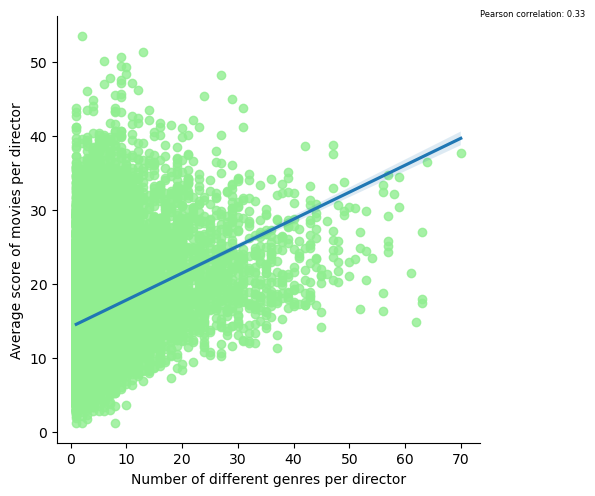

In [230]:
from scipy.stats import pearsonr

sns.lmplot(x = 'number_different_genres', y='score', data=success_movies_genres_per_director, scatter_kws={'color': 'lightgreen'})

corr_coef, _ = pearsonr(success_movies_genres_per_director['number_different_genres'], success_movies_genres_per_director['score'])
plt.annotate(f'Pearson correlation: {corr_coef:.2f}', xy=(1, 1), xycoords='axes fraction', fontsize=6)

plt.xlabel('Number of different genres per director')
plt.ylabel('Average score of movies per director')

Success of directors in relation to the number of different film genres per director

In [231]:
# extract success of directors
success_directors = directors[['nconst','primaryName','avg-3']]
success_directors = success_directors.rename(columns={'nconst': 'directors'})
success_directors_genres = pd.merge(success_directors, movies[['directors','genres']], on='directors').dropna()


# split genre
success_directors_genres['genre_split'] = success_directors_genres['genres'].str.split(',')
success_directors_genres = success_directors_genres.groupby('primaryName').agg({'genre_split': 'sum', 'avg-3': 'mean'}).reset_index()
success_directors_genres['number_different_genres'] = success_directors_genres['genre_split'].apply(lambda x: len(set(x)))
success_directors_genres= success_directors_genres.dropna()

success_directors_genres = success_directors_genres.sort_values(by='avg-3', ascending=False)
success_directors_genres


,primaryName,genre_split,avg-3,number_different_genres
952,Christopher Nolan,"[Thriller, Crime Fiction, Remake, Psychologica...",56.359359,27
4409,Peter Jackson,"[Fantasy Adventure, Adventure, Epic, Action/Ad...",55.600284,42
1629,Francis Ford Coppola,"[Thriller, Horror, Drama, Road movie, Feminist...",54.015733,58
4552,Quentin Tarantino,"[Thriller, Crime Fiction, Indie, Action/Advent...",53.710729,24
5458,Steven Spielberg,"[Thriller, Docudrama, Sports, Period piece, Dr...",52.930622,70
...,...,...,...,...
1852,George Young,"[Silent film, Silent film, Silent film, Silent...",4.388504,1
1391,E.J. Cole,"[Silent film, Silent film, Silent film, Silent...",4.339784,1
1774,Gaston Mervale,"[Silent film, Silent film, Silent film, Silent...",4.30939,2
4576,Rafael Cohen,"[Romance Film, Comedy film, Musical, Comedy, C...",3.611716,4


In [232]:
print(success_directors_genres['number_different_genres'].dtype)
print(success_directors_genres['avg-3'].dtype)
success_directors_genres['avg-3'] = pd.to_numeric(success_directors_genres['avg-3'])

int64
object


c:\Users\clem7\anaconda3\envs\ada\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(33.37500000000001, 0.5, 'Average score of directors')

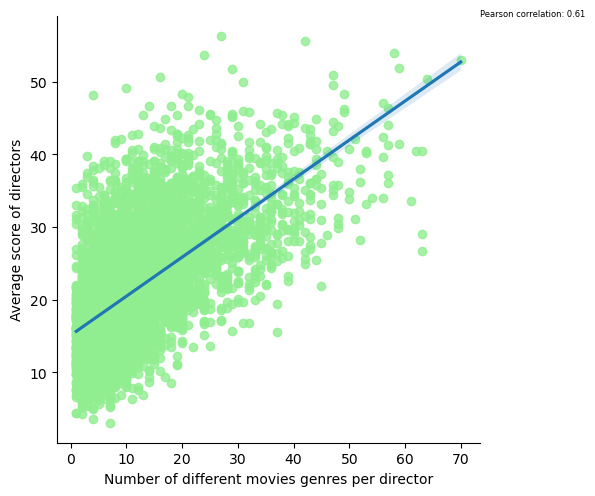

In [233]:
sns.lmplot(x = 'number_different_genres', y='avg-3', data=success_directors_genres, scatter_kws={'color': 'lightgreen'})

corr_coef, _ = pearsonr(success_directors_genres['number_different_genres'], success_directors_genres['avg-3'])
plt.annotate(f'Pearson correlation: {corr_coef:.2f}', xy=(1, 1), xycoords='axes fraction', fontsize=6)

plt.xlabel('Number of different movies genres per director')
plt.ylabel('Average score of directors')

In [234]:

success_directors_genres_filtered = success_directors_genres.iloc[0:30,:]
success_directors_genres_filtered = success_directors_genres_filtered.reset_index()


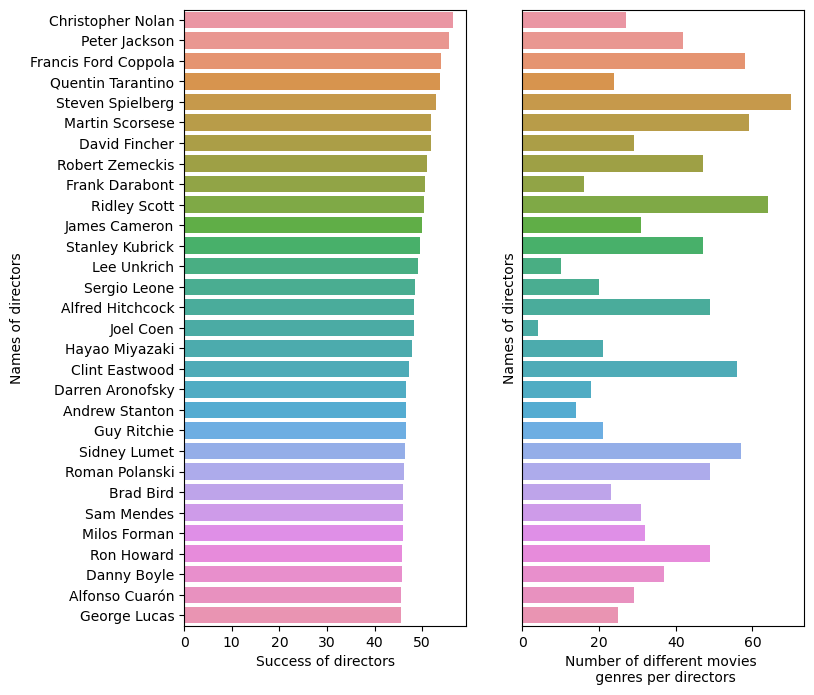

In [238]:
fig, axs = plt.subplots(1, 2, figsize=(8, 8))
sns.barplot(y='primaryName', x='avg-3', data=success_directors_genres_filtered,orient='h', ax=axs[0])
axs[0].set_title('')
axs[0].set_xlabel('Success of directors')
axs[0].set_ylabel('Names of directors')

sns.barplot(y='primaryName', x='number_different_genres', data=success_directors_genres_filtered, orient='h', ax=axs[1])
axs[1].set_yticks([])
axs[1].set_ylabel('Names of directors')
axs[1].set_xlabel('Number of different movies \n genres per directors')

plt.show()

Best combination of genres in relation to the success of the film

Text(0, 0.5, 'Genres')

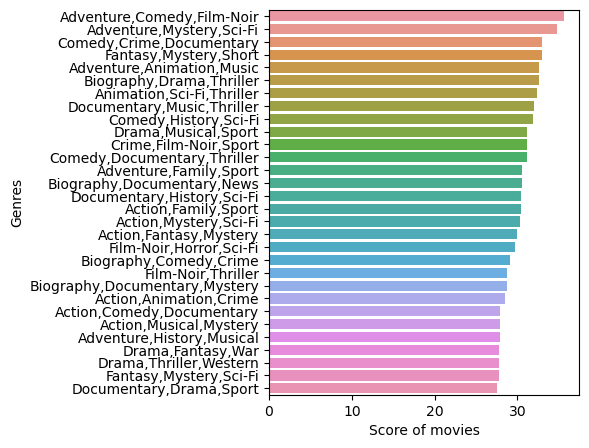

In [274]:
genres_success = movies.groupby('genres_imdb')['score'].mean().reset_index()
genres_success = genres_success.sort_values(by='score', ascending=False).dropna()
genres_success_filtered = genres_success.iloc[0:30,:]

plt.figure(figsize=(4,5))
sns.barplot(y='genres_imdb', x='score', data=genres_success_filtered,orient='h')
plt.xlabel('Score of movies')
plt.ylabel('Genres')

Best genre in ralation to the succes of a film

C:\Users\clem7\AppData\Local\Temp\ipykernel_33124\793891256.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best_genres['genre_split'] = best_genres['genres_imdb'].str.split(',')


Text(0, 0.5, 'Genres')

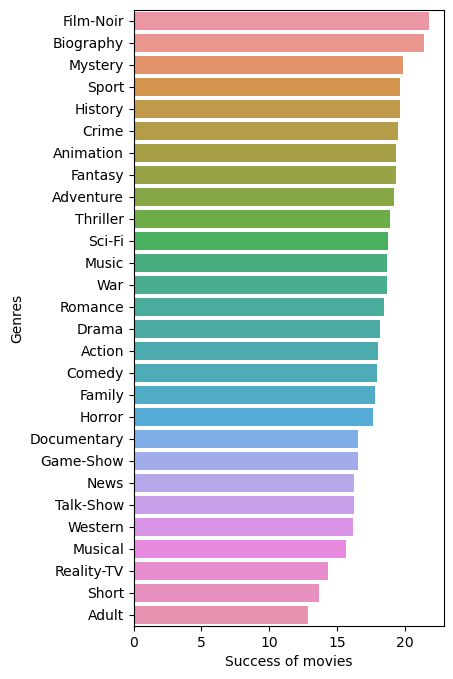

In [273]:
best_genres = movies[['genres_imdb','score']]

best_genres['genre_split'] = best_genres['genres_imdb'].str.split(',')
best_genres = best_genres.explode('genre_split').reset_index()
best_genres = best_genres.groupby(by='genre_split')['score'].mean().reset_index()
best_genres = best_genres.sort_values(by='score', ascending=False).reset_index()

plt.figure(figsize=(4,8))
sns.barplot(y='genre_split', x='score', data=best_genres,orient='h')
plt.xlabel('Success of movies')
plt.ylabel('Genres')
